In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# df = pd.read_csv('GDSC1_melanoma_BRAF_5conc_noreps_v3.csv')
# X = df[['param_1', 'param_2', 'param_3',
#        'param_4','ARID1A_mut', 'ARID2_mut', 'BRAF_mut', 'CDKN2A_mut',
#        'EZH2_mut', 'MECOM_mut', 'NF1_mut', 'NRAS_mut', 'PLCB1_mut', 'PTEN_mut',
#        'TP53_mut', 'loss.cnaSKCM3', 'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.',
#        'loss.cnaSKCM5..PAX5.', 'loss.cnaSKCM9', 'gain.cnaSKCM12..KRAS.',
#        'gain.cnaSKCM21..FOXP1.MITF.', 'loss.cnaSKCM22', 'loss.cnaSKCM23',
#        'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM26',
#        'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM28', 'loss.cnaSKCM30']].values
# y = df[['norm_cells_1', 'norm_cells_2', 'norm_cells_3',
#        'norm_cells_4', 'norm_cells_5']].values

X_df=None
X_domain_info=None
y_df=None
with open('X_df.pkl', 'rb') as f:
    X_df = pickle.load(f)
with open('X_domain_info.pkl', 'rb') as f:
    X_domain_info = pickle.load(f)
with open('y_df.pkl', 'rb') as f:
    y_df = pickle.load(f)

num_conc=y_df.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.1, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [3]:


X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)


In [4]:
class HomemadeRBF(Kernel):\
#TODO embed the domain information
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Define a hyperparameter called 'scale'
        self.homemade_lengthscale = torch.nn.Parameter(torch.tensor(1.0))
        
        # Register the hyperparameter
        self.register_parameter(name='homemade_lengthscale', parameter=self.homemade_lengthscale)
    def forward(self, x1, x2,**params):
        # 扩展维度以便广播
        x1_expanded = x1.unsqueeze(1)  # (8, 1, 28)
        x2_expanded = x2.unsqueeze(0)  # (1, 80, 28)

        variance_matrix = torch.var(x1_expanded - x2_expanded, dim=2)

        return torch.exp(-variance_matrix/(2*(self.homemade_lengthscale**2)))
            


In [5]:
class QuadripleDRPKernel(Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Use a base kernel, e.g., RBFKernel
        self.kernel_mu = gpytorch.kernels.RBFKernel()
        self.kernel_met = gpytorch.kernels.RBFKernel()
        self.kernel_cn = gpytorch.kernels.RBFKernel()
        self.kernel_dc = gpytorch.kernels.RBFKernel()
    
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=0
        filter_met=0
        filter_cn=0
        filter_dc=0
        
        # Use the scale hyperparameter
        return self.scale * 1

In [6]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            HomemadeRBF(), num_tasks=num_conc, rank=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = MultitaskGPModel(X_train_tensor, y_train_tensor, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 150


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/150 - Loss: 1.133
Iter 2/150 - Loss: 1.093
Iter 3/150 - Loss: 1.054
Iter 4/150 - Loss: 1.015
Iter 5/150 - Loss: 0.976
Iter 6/150 - Loss: 0.936
Iter 7/150 - Loss: 0.897
Iter 8/150 - Loss: 0.857
Iter 9/150 - Loss: 0.817
Iter 10/150 - Loss: 0.777
Iter 11/150 - Loss: 0.736
Iter 12/150 - Loss: 0.696
Iter 13/150 - Loss: 0.655
Iter 14/150 - Loss: 0.614
Iter 15/150 - Loss: 0.573
Iter 16/150 - Loss: 0.532
Iter 17/150 - Loss: 0.492
Iter 18/150 - Loss: 0.452
Iter 19/150 - Loss: 0.411
Iter 20/150 - Loss: 0.372
Iter 21/150 - Loss: 0.333
Iter 22/150 - Loss: 0.294
Iter 23/150 - Loss: 0.257
Iter 24/150 - Loss: 0.220
Iter 25/150 - Loss: 0.185
Iter 26/150 - Loss: 0.150
Iter 27/150 - Loss: 0.117
Iter 28/150 - Loss: 0.085
Iter 29/150 - Loss: 0.054
Iter 30/150 - Loss: 0.024
Iter 31/150 - Loss: -0.004
Iter 32/150 - Loss: -0.032
Iter 33/150 - Loss: -0.060
Iter 34/150 - Loss: -0.088
Iter 35/150 - Loss: -0.116
Iter 36/150 - Loss: -0.144
Iter 37/150 - Loss: -0.172
Iter 38/150 - Loss: -0.199
Iter 39/150 -

In [8]:
def smooth_curve(x, y, num_points=300):
    # 创建平滑的曲线
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    return x_smooth, y_smooth

# Set into eval mode
model.eval()
likelihood.eval()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



c:\Users\25858\anaconda3\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Num 9 Chosen for display
[1.0021792650222778, 0.9929407835006714, 0.9390578269958496, 0.8606024384498596, 0.6470329761505127, 0.34316277503967285, 0.10612373799085617, 0.02533281221985817, 0.014806034043431282, 0.012200097553431988]
[0.9981793165206909, 0.9889408349990845, 0.9350578784942627, 0.8566024899482727, 0.6430330276489258, 0.33916276693344116, 0.10212374478578568, 0.021332811564207077, 0.01080603338778019, 0.008200096897780895]


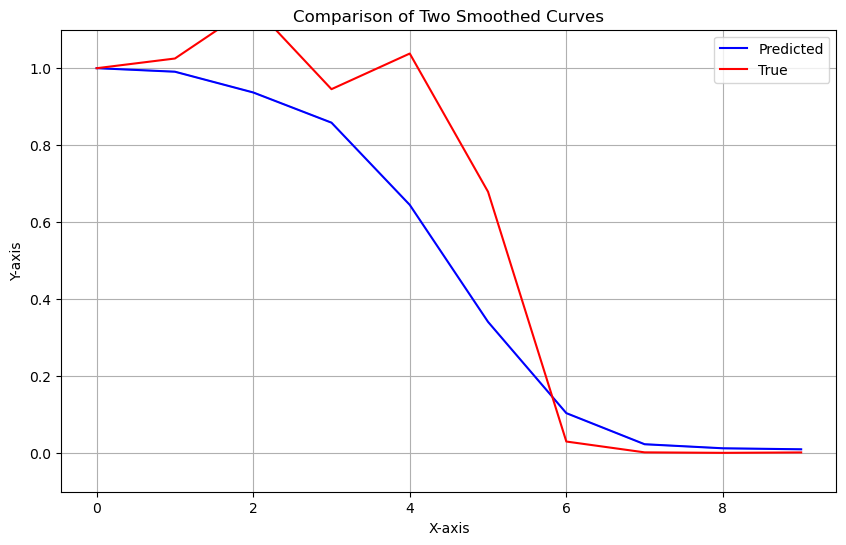

In [9]:

x_plt_axis = np.arange(len(mean[0]))

random_num = np.random.randint(0, len(mean), size=1)[0]
y_pred=mean[random_num]
y_true=y_test_tensor[random_num]
print("Num "+str(random_num)+" Chosen for display")
x_plt_axis = np.linspace(0, len(y_pred) - 1, len(y_pred))
# 创建图形、
selected_upper_bound=lower[random_num].numpy().tolist()
selected_lower_bound=upper[random_num].numpy().tolist()

print(selected_lower_bound)
print(selected_upper_bound)
plt.figure(figsize=(10, 6))
plt.plot(x_plt_axis, y_pred, label='Predicted', color='blue')
plt.plot(x_plt_axis, y_true, label='True', color='red')
plt.fill_between(x_plt_axis, selected_lower_bound, selected_upper_bound, alpha=0.5)
plt.ylim(-0.1, 1.1)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
